In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sncosmo
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, RationalQuadratic, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import GPy
import pickle
import bz2
import emcee
from multiprocessing import Pool
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.rcParams['font.size'] = 20.

p_grid=np.arange(-10,51,1)
w_grid_reg=np.arange(3310,8585,10) # mudar para 3310 após comparação
w_grid_plot=np.arange(3350,8585,50)

In [2]:
fname=[]
for file in glob.glob("./SEDs_reg/*.dat"):
    fname.append(file.split("/")[2].split(".")[0])

In [3]:
data={}

In [4]:
exclude=["Train_SN93_v2_SED","Test_SN15_v2_SED","Test_SN26_v2_SED","Train_SN30_v2_SED","Train_SN96_v2_SED"]

In [5]:
for sn in fname:
    if sn not in exclude:
        data[sn]=pd.read_csv(f"./SEDs_reg/{sn}.dat")
    else:
        continue

In [6]:
sum_surf=np.array([0.]*len(p_grid)*len(w_grid_reg))
for sn in data.keys():
    sum_surf+=data[sn]["flux"].values

In [7]:
mean_surf=sum_surf/len(fname)

In [8]:
X,Y=np.meshgrid(p_grid,w_grid_reg)

In [9]:
Z=mean_surf.reshape(len(w_grid_reg),len(p_grid))

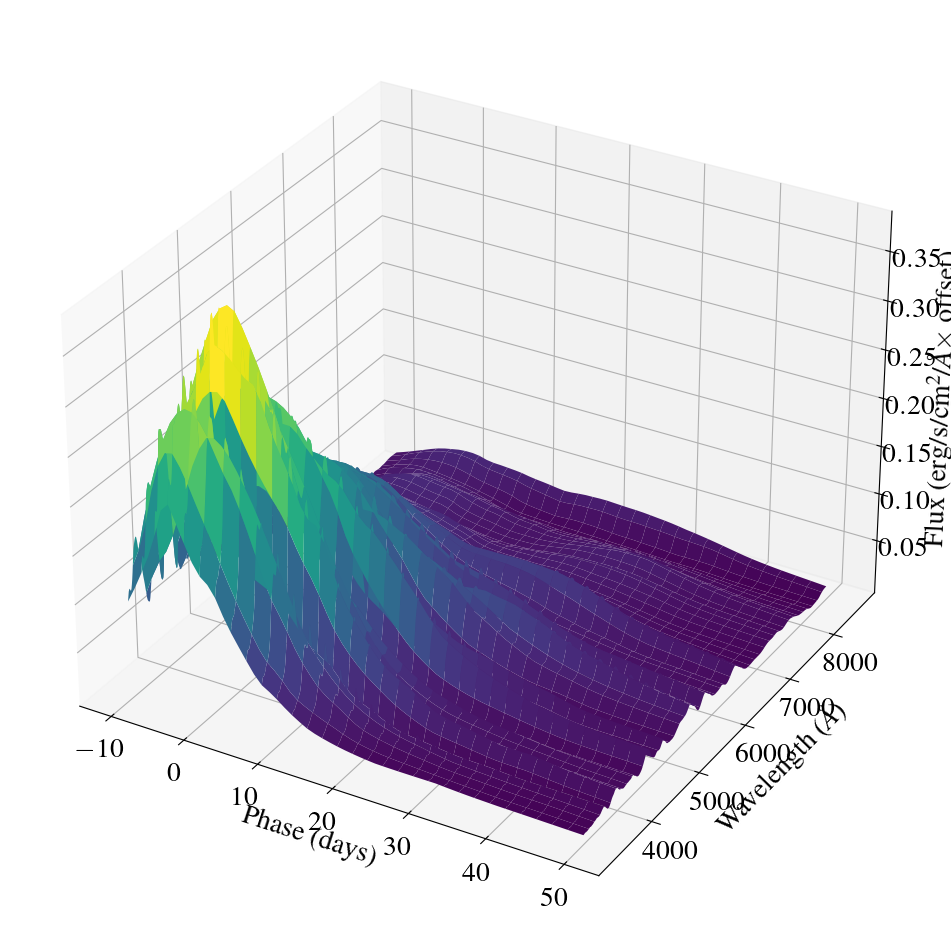

In [10]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z,cmap='viridis', edgecolor='none')
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)");

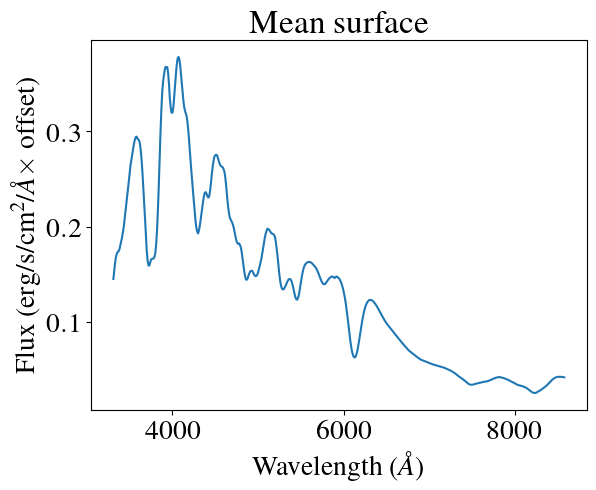

In [11]:
plt.plot(Y[::,10],Z[::,10])
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
plt.title("Mean surface");

In [12]:
mean_lc_max=sncosmo.Spectrum(wave=Y[::,10], flux=Z[::,10], fluxerr=None, fluxcov=None, bin_edges=None, time=0.)    

In [13]:
mean_integral_value=mean_lc_max.bandflux('desg') # units of photons / s / cm^2

0.0


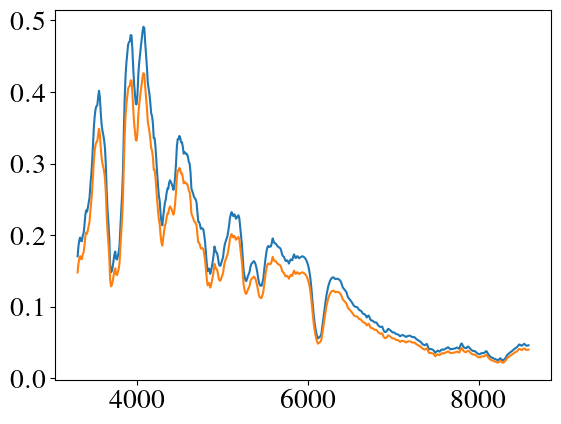

In [14]:
for sn in ["Test_SN0_v2_SED"]:
    w=data[sn]["wave"].values.reshape(len(w_grid_reg),len(p_grid))[::,10]
    f=data[sn]["flux"].values.reshape(len(w_grid_reg),len(p_grid))[::,10]
    spec=sncosmo.Spectrum(wave=w, flux=f, fluxerr=None, fluxcov=None, bin_edges=None, time=0.)
    fac=mean_integral_value/spec.bandflux('desg')
    spec2=sncosmo.Spectrum(wave=w, flux=f*fac, fluxerr=None, fluxcov=None, bin_edges=None, time=0.)
    print(spec2.bandflux('desg')-mean_integral_value)
    plt.plot(w,f)
    plt.plot(w,f*fac)

In [15]:
factor={}

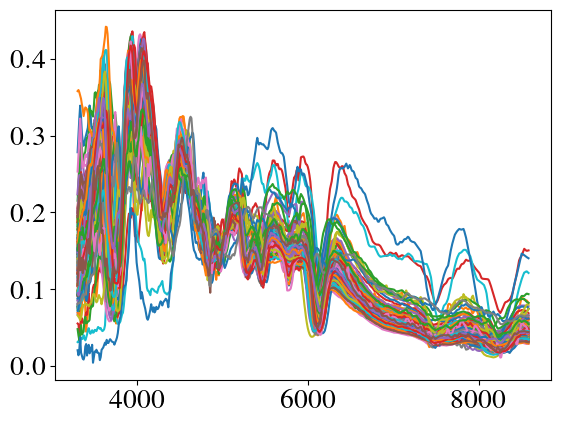

In [16]:
for sn in data.keys():
    w=data[sn]["wave"].values.reshape(len(w_grid_reg),len(p_grid))[::,10]
    f=data[sn]["flux"].values.reshape(len(w_grid_reg),len(p_grid))[::,10]
    spec=sncosmo.Spectrum(wave=w, flux=f, fluxerr=None, fluxcov=None, bin_edges=None, time=0.)
    factor[sn]=mean_integral_value/spec.bandflux('desg')
    spec2=sncosmo.Spectrum(wave=w, flux=f*factor[sn], fluxerr=None, fluxcov=None, bin_edges=None, time=0.)
    #plt.plot(w,f)
    plt.plot(w,f*factor[sn])

In [17]:
for sn in data.keys():
    norm_flux=factor[sn]*data[sn]["flux"].values
    norm_fluxerr=factor[sn]*data[sn]["fluxerr"].values
    df=pd.DataFrame((data[sn]["phase"].values,data[sn]["wave"].values,norm_flux,norm_fluxerr)).T
    df.columns=["phase","wave","flux","fluxerr"]
    df.to_csv(f"./SEDs_reg_normalized/{sn}_normalized.dat",index=None)

In [18]:
factor

{'Train_SN3_v2_SED': 0.6381181325878172,
 'Test_SN2_v2_SED': 4.06577182647865,
 'Test_SN36_v2_SED': 1.565562171368448,
 'Train_SN38_v2_SED': 7.020588032394896,
 'Train_SN46_v2_SED': 0.2702964926516807,
 'Train_SN15_v2_SED': 0.9482264629840431,
 'Train_SN17_v2_SED': 1.6951168127309246,
 'Test_SN22_v2_SED': 0.9107889692040416,
 'Train_SN0_v2_SED': 1.2209216276469685,
 'Train_SN7_v2_SED': 10.666638474292382,
 'Train_SN80_v2_SED': 0.7889296301952722,
 'Train_SN62_v2_SED': 1.0250447802613987,
 'Test_SN42_v2_SED': 0.7188638906448819,
 'Train_SN63_v2_SED': 0.8951956970011413,
 'Train_SN84_v2_SED': 1.2716271261863406,
 'Train_SN100_v2_SED': 0.7535603109684639,
 'Train_SN68_v2_SED': 1.354826811780013,
 'Train_SN110_v2_SED': 1.1179385015214285,
 'Train_SN78_v2_SED': 1.163459414027675,
 'Test_SN32_v2_SED': 0.8955785998971274,
 'Train_SN33_v2_SED': 0.7891531946798197,
 'Test_SN7_v2_SED': 0.681006617544471,
 'Test_SN40_v2_SED': 1.8069984086161668,
 'Test_SN25_v2_SED': 2.1778949926896867,
 'Train_SN

In [19]:
factor["Test_SN0_v2_SED"]

0.8679339070324895

In [20]:
factor["Test_SN30_v2_SED"]

0.8911402931956812

In [21]:
factor["Train_SN17_v2_SED"]

1.6951168127309246

In [22]:
factor["Train_SN10_v2_SED"]

1.0377985736360944